<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper_figs/interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to generate interpretable results using deep learning model. The deep learning model used is Dual stage LSTM model of [Qin et al., 2017](https://arxiv.org/abs/1704.02971). The dataset used is of [Camels Australia](https://essd.copernicus.org/preprints/essd-2020-228/)

In [1]:
try:
    import AI4Water
except ImportError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should ins

In [2]:
import os

import numpy as np 
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
seed = 313
np.random.seed(seed)

In [5]:
from ai4water import DualAttentionModel
from ai4water.datasets import CAMELS_AUS
from ai4water.utils.utils import dateandtime_now
from ai4water.utils.utils import Jsonize
from ai4water.postprocessing import Interpret

In [6]:
dataset = CAMELS_AUS()

inputs = ['et_morton_point_SILO',
           'precipitation_AWAP',
           'tmax_AWAP',
           'tmin_AWAP',
           'vprp_AWAP',
           'rh_tmax_SILO',
           'rh_tmin_SILO'
          ]

outputs = ['streamflow_MLd']

data = dataset.fetch('401203', dynamic_attributes=inputs+outputs, as_dataframe=True)
data

0% of 0.01 MB downloaded
100% of 0.01 MB downloaded
0% of 32.25 MB downloaded
100% of 32.25 MB downloaded
0% of 39.85 MB downloaded
100% of 39.85 MB downloaded
0% of 0.57 MB downloaded
100% of 0.57 MB downloaded
0% of 861.93 MB downloaded
6% of 861.93 MB downloaded
12% of 861.93 MB downloaded
18% of 861.93 MB downloaded
24% of 861.93 MB downloaded
30% of 861.93 MB downloaded
36% of 861.93 MB downloaded
42% of 861.93 MB downloaded
48% of 861.93 MB downloaded
54% of 861.93 MB downloaded
60% of 861.93 MB downloaded
66% of 861.93 MB downloaded
72% of 861.93 MB downloaded
78% of 861.93 MB downloaded
100% of 861.93 MB downloaded
0% of 0.28 MB downloaded
100% of 0.28 MB downloaded
0% of 0.15 MB downloaded
100% of 0.15 MB downloaded
0% of 0.13 MB downloaded
100% of 0.13 MB downloaded
unziping /usr/local/lib/python3.7/dist-packages/AI4Water/utils/datasets/data/CAMELS/CAMELS_AUS/05_hydrometeorology.zip to /usr/local/lib/python3.7/dist-packages/AI4Water/utils/datasets/data/CAMELS/CAMELS_AUS/05_hy

,et_morton_point_SILO,precipitation_AWAP,tmax_AWAP,tmin_AWAP,vprp_AWAP,rh_tmax_SILO,rh_tmin_SILO,streamflow_MLd
1957-01-01,8.062837,0.0,20.784480,4.358533,8.142806,28.888577,88.900993,538.551
1957-01-02,8.519483,0.0,27.393169,4.835900,5.281136,23.516738,99.002080,531.094
1957-01-03,9.879688,0.0,28.945301,8.175408,12.920509,19.434872,77.429917,503.011
1957-01-04,6.744638,0.0,26.133843,7.017990,13.951027,42.350667,100.000000,484.512
1957-01-05,8.135359,0.0,21.450775,8.686258,12.168659,30.374862,87.634483,463.416


In [ ]:
data = data.unstack()
data.columns = [a[1] for a in data.columns.to_flat_index()]
data.head()

In [7]:
data.shape

(22645, 8)

In [8]:
(data['streamflow_MLd'].values<0.0).sum()

0

In [9]:
(data['streamflow_MLd'].values==0.0).sum()

0

In [10]:
data.isna().sum()

et_morton_point_SILO       0
precipitation_AWAP       365
tmax_AWAP                365
tmin_AWAP                365
vprp_AWAP                365
rh_tmax_SILO               0
rh_tmin_SILO               0
streamflow_MLd          1461
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f2cd408d0>,
      dtype=object)

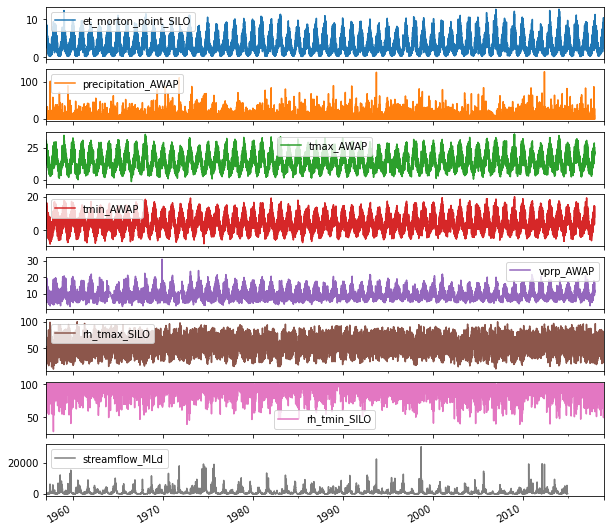

In [11]:
data.plot(subplots=True, sharex=True, figsize=(10, 10))

In [12]:
def objective_fn(return_model=False,
                 prefix=None,
                 **suggestion):

    suggestion = Jsonize(suggestion)()

    _model = DualAttentionModel(
                    data=data,
                    input_features=inputs,
                    output_features=outputs,
                    patience=50,
                    epochs=500,
                    train_data='random',
                    lookback=int(suggestion['lookback']),
                    lr=suggestion['lr'],
                    batch_size=int(suggestion['batch_size']),
                    transformation=[{'method': 'robust', 'features': inputs},
                                    {'method': 'log', "replace_nans": True, "replace_zeros": True, 'features': outputs},
                                    {'method': 'robust', "replace_nans": True, 'features': outputs}
                                    ],
                    prefix=prefix
                    )

    h = _model.fit()
    min_val_loss = float(np.min(h.history['val_loss']))
    print(f'with {suggestion} min val loss is {min_val_loss}')

    if return_model:
        return _model
    return _model


In [13]:
model = objective_fn(return_model=True,
                     lookback=15, lr=0.0001, batch_size=64)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 15, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7)            0           enc_input[0][0]                  
__________________________________________________________________________________________________
enc_first_hidden_state_1 (Input [(None, 20)]         0                                            
__________________________________________________________________________________________________
enc_first_cell_state_1 (InputLa [(None, 20)]         0                                            
_______________________________________________________________________________________

Making predictions on training data


********** Removing Samples with nan labels  **********

input_x shape:  [(16935, 15, 7), (16935, 14, 1), (16935, 20), (16935, 20), (16935, 30), (16935, 30)]
target shape:  (16935, 1, 1)


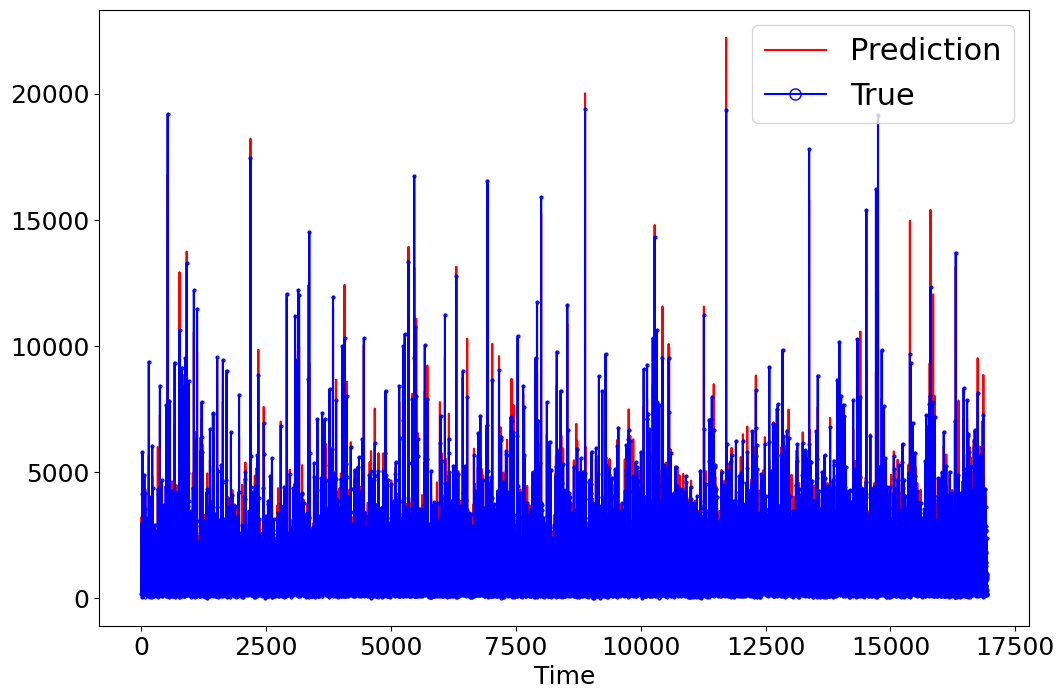

In [14]:
_ = model.predict('training')

Making predictions on test data


********** Removing Samples with nan labels  **********

input_x shape:  [(4234, 15, 7), (4234, 14, 1), (4234, 20), (4234, 20), (4234, 30), (4234, 30)]
target shape:  (4234, 1, 1)


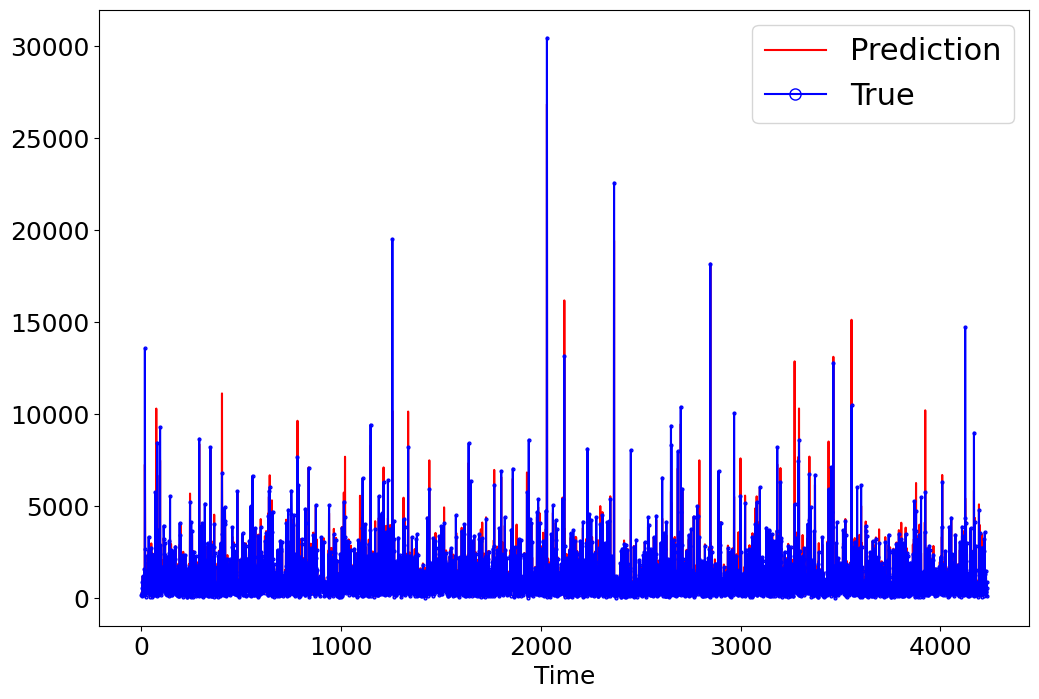

In [15]:
_ = model.predict()

Getting interpretable results

In [16]:
Interpret(model)


********** Removing Samples with nan labels  **********

input_x shape:  [(21170, 15, 7), (21170, 14, 1), (21170, 20), (21170, 20), (21170, 30), (21170, 30)]
target shape:  (21170, 1, 1)

********** Removing Samples with nan labels  **********

input_x shape:  [(21170, 15, 7), (21170, 14, 1), (21170, 20), (21170, 20), (21170, 30), (21170, 30)]
target shape:  (21170, 1, 1)


In [17]:
print(f'All results are saved in {model.path}')

All results are saved in /content/results/20210606_082646
